In [2]:
import numpy as np 
import pandas as pd
import pickle

In [3]:
exp = 'CheXpertPlus_mimiccxr'

In [4]:
# load prediction
if exp == 'CheXpertPlus_mimiccxr':
    with open('/restricted/projectnb/batmanlab/chyuwang/rrg_factual_uncertainty/exp/chexpert-plus/batch_chexpert_mimix_cxr_num3858.pkl', 'rb') as file:
        chexpert_plus = pickle.load(file)
    pred = chexpert_plus['greedy_reports']
else:
    all_pred = pd.read_csv("/restricted/projectnb/batmanlab/chyuwang/RaDialog/chexbert/outputs/predictions/predictions_checkpoints_vicuna-7b-img-report_checkpoint-11200.csv",header=None)
    all_pred_list = all_pred.values.tolist()
    pred = [item[0] for item in all_pred_list] 

In [9]:
chexpert_plus['sampled_reports'][0]

('lung volumes are low. there is no focal consolidation, effusion, or pneumothorax. aortic and mitral valve replacements are present. sternal wires are intact. no free air below the right hemidiaphragm is seen.',
 'the lungs are clear without consolidation or edema. there is no pleural effusion or pneumothorax. unchanged appearance of a cardiomediastinal silhouette, including multiple sternotomy wires and mediastinal clips. surgical clips are noted projecting over the left hemithorax with a wire extending from the left coronary sinus to the left of midline, unchanged. a well - defined wire like density projecting just to the left of the mid trachea and left of the trachea possibly representing a mechanical brachiocephalic artery stent.',
 'ap upright and lateral chest radiograph demonstrates median sternotomy wires and mediastinal clips again seen. there is no evidence of overt pulmonary edema or pneumonia. cardiac silhouette is unchanged, and no large pleural effusions or pneumothorax

In [3]:
# load sentence uq
with open('/restricted/projectnb/batmanlab/chyuwang/RaDialog/exp/uncertainty/new_rad_cent_consistent-3858.pkl', 'rb') as file:
       rad_all_cent = pickle.load(file)

In [4]:
with open('/restricted/projectnb/batmanlab/chyuwang/RaDialog/exp/uncertainty/green_uncertainty-3858.pkl', 'rb') as file:
    green_uncertainty = pickle.load(file)
ugreen = np.array([t.numpy() for t in green_uncertainty['uncertainty']])

In [12]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
# Substrings to be checked, taken from the image
reference_substrings = {
    "more", "regress", "advance", "less", "fewer", "constant", "unchanged", "prior", 
    "new", "stable", "progressed", "interval", "previous", "further", "again", "since", 
    "increase", "improve", "remain", "worse", "persist", "remov", "similar", "cleared", 
    "earlier", "existing", "decrease", "reduc", "recurrent", "redemonstrat", "resolv", 
    "still", "has", "enlarged", "lower", "larger", "extubated", "smaller", "higher", 
    "continue", "compar", "change", "develop", "before"
}

In [13]:
# from collections import defaultdict
# substring_count_dict = defaultdict(int)
# for idx, report in enumerate(pred):
#     # Convert report to lowercase for case-insensitive matching
#     report_lower = report.lower()
#     # Count occurrences of each substring in the report
#     count = sum(1 for substring in reference_substrings if substring in report_lower)
#     substring_count_dict[idx] = count
# substring_count_dict = dict(substring_count_dict)
def count_substrings(pred, reference_substrings):
    """
    This function takes a list of reports and a set of reference substrings,
    then calculates how many of these substrings appear in each report.
    
    Parameters:
    - pred: list of strings (reports)
    - reference_substrings: set of substrings to search for in the reports
    
    Returns:
    - A dictionary with the report index as the key and the count of substrings as the value
    """
    # Initialize a dictionary to store the count of substrings for each report
    substring_count_dict = defaultdict(int)
    
    # Process each report and count substrings
    for idx, report in enumerate(pred):
        # Convert report to lowercase for case-insensitive matching
        report = str(report)
        report_lower = report.lower()
        # Count occurrences of each substring in the report
        count = sum(1 for substring in reference_substrings if substring in report_lower)
        substring_count_dict[idx] = count
    
    return dict(substring_count_dict)


def plot_distribution(substring_count_dict):
    """
    This function takes a dictionary of substring counts and plots the distribution.
    
    Parameters:
    - substring_count_dict: dictionary with report index as key and count of substrings as value
    """
    # Calculate the distribution of the counts
    value_distribution = Counter(substring_count_dict.values())
    # Plot the distribution of values
    plt.figure(figsize=(10, 6))
    plt.bar(value_distribution.keys(), value_distribution.values(), width=0.5, edgecolor='black')
    # Adding titles and labels
    plt.title('Distribution of Substring Counts in Reports')
    plt.xlabel('Count of Substrings')
    plt.ylabel('Number of Reports')
    # Display the plot
    plt.show()

    
import random

def exclude_top_uncertainty_analysis(pred, reference_substrings, ugreen, top_percent=0.2):
    """
    This function calculates the count of substrings for reports excluding the top X% of uncertainty values
    and for an equivalent number of randomly selected reports as a baseline.
    
    Parameters:
    - pred: list of strings (reports)
    - reference_substrings: set of substrings to search for in the reports
    - ugreen: list of uncertainty values corresponding to each report
    - top_percent: the top percentage of uncertainty values to exclude (default is 20%)
    
    Returns:
    - excluded_substring_count_dict: A dictionary with the report index as the key and the count of substrings for reports excluding top uncertain reports
    - random_substring_count_dict: A dictionary with the report index as the key and the count of substrings for randomly selected reports
    """
    # Determine the threshold for the top X% of uncertainty values
    threshold = sorted(ugreen, reverse=True)[int(len(ugreen) * top_percent) - 1]

    # Identify the indices of reports that are below the top X% uncertainty
    remaining_indices = [idx for idx, uncertainty in enumerate(ugreen) if uncertainty < threshold]
    
    # Get the reports corresponding to the remaining indices
    remaining_pred = [pred[idx] for idx in remaining_indices]
    
    # Get the substring count for these reports
    excluded_substring_count_dict = count_substrings(remaining_pred, reference_substrings)
    
    # Randomly select the same number of reports as the remaining reports
    random_indices = random.sample(range(len(pred)), len(remaining_indices))
    random_pred = [pred[idx] for idx in random_indices]
    
    # Get the substring count for these randomly selected reports
    random_substring_count_dict = count_substrings(random_pred, reference_substrings)
    
    # Adjust the keys in the dictionaries to match the original report indices
    excluded_substring_count_dict = {remaining_indices[idx]: count 
                                     for idx, count in excluded_substring_count_dict.items()}
    
    random_substring_count_dict = {random_indices[idx]: count 
                                   for idx, count in random_substring_count_dict.items()}
    
    return excluded_substring_count_dict, random_substring_count_dict



In [14]:
top_substring_count_dict, random_substring_count_dict = exclude_top_uncertainty_analysis(pred, reference_substrings, ugreen, top_percent=0.2)

# Calculate metrics for top uncertain reports (excluding top uncertain reports)
non_zero_count = sum(1 for count in top_substring_count_dict.values() if count > 0)
print(non_zero_count)
print(f'Percentage of reports with prior reference (excluding top uncertainty): {non_zero_count / len(top_substring_count_dict)}')
print(f'Number of prior substrings per report (excluding top uncertainty): {np.mean(list(top_substring_count_dict.values()))}')

# Run the random sampling 5 times and take the average
rd_non_zero_counts = []
rd_avg_prior_substrings = []

for _ in range(5):
    _, random_substring_count_dict = exclude_top_uncertainty_analysis(pred, reference_substrings, ugreen, top_percent=0.2)
    
    # Calculate metrics for each random sample
    rd_non_zero_count = sum(1 for count in random_substring_count_dict.values() if count > 0)
    rd_non_zero_counts.append(rd_non_zero_count / len(random_substring_count_dict))  # Percentage of reports with prior reference
    rd_avg_prior_substrings.append(np.mean(list(random_substring_count_dict.values())))  # Average number of prior substrings per report

# Calculate the average of the metrics from the 5 random samples
avg_rd_non_zero_count = np.mean(rd_non_zero_counts)
avg_rd_avg_prior_substrings = np.mean(rd_avg_prior_substrings)

# Output the averaged results for random sampling
print(f'Random (average over 5 runs) - Percentage of reports with prior reference: {avg_rd_non_zero_count}')
print(f'Random (average over 5 runs) - Number of prior substrings per report: {avg_rd_avg_prior_substrings}')


1932
Percentage of reports with prior reference (excluding top uncertainty): 0.6258503401360545
Number of prior substrings per report (excluding top uncertainty): 1.9229024943310657
Random (average over 5 runs) - Percentage of reports with prior reference: 0.6589569160997734
Random (average over 5 runs) - Number of prior substrings per report: 2.221963070942663


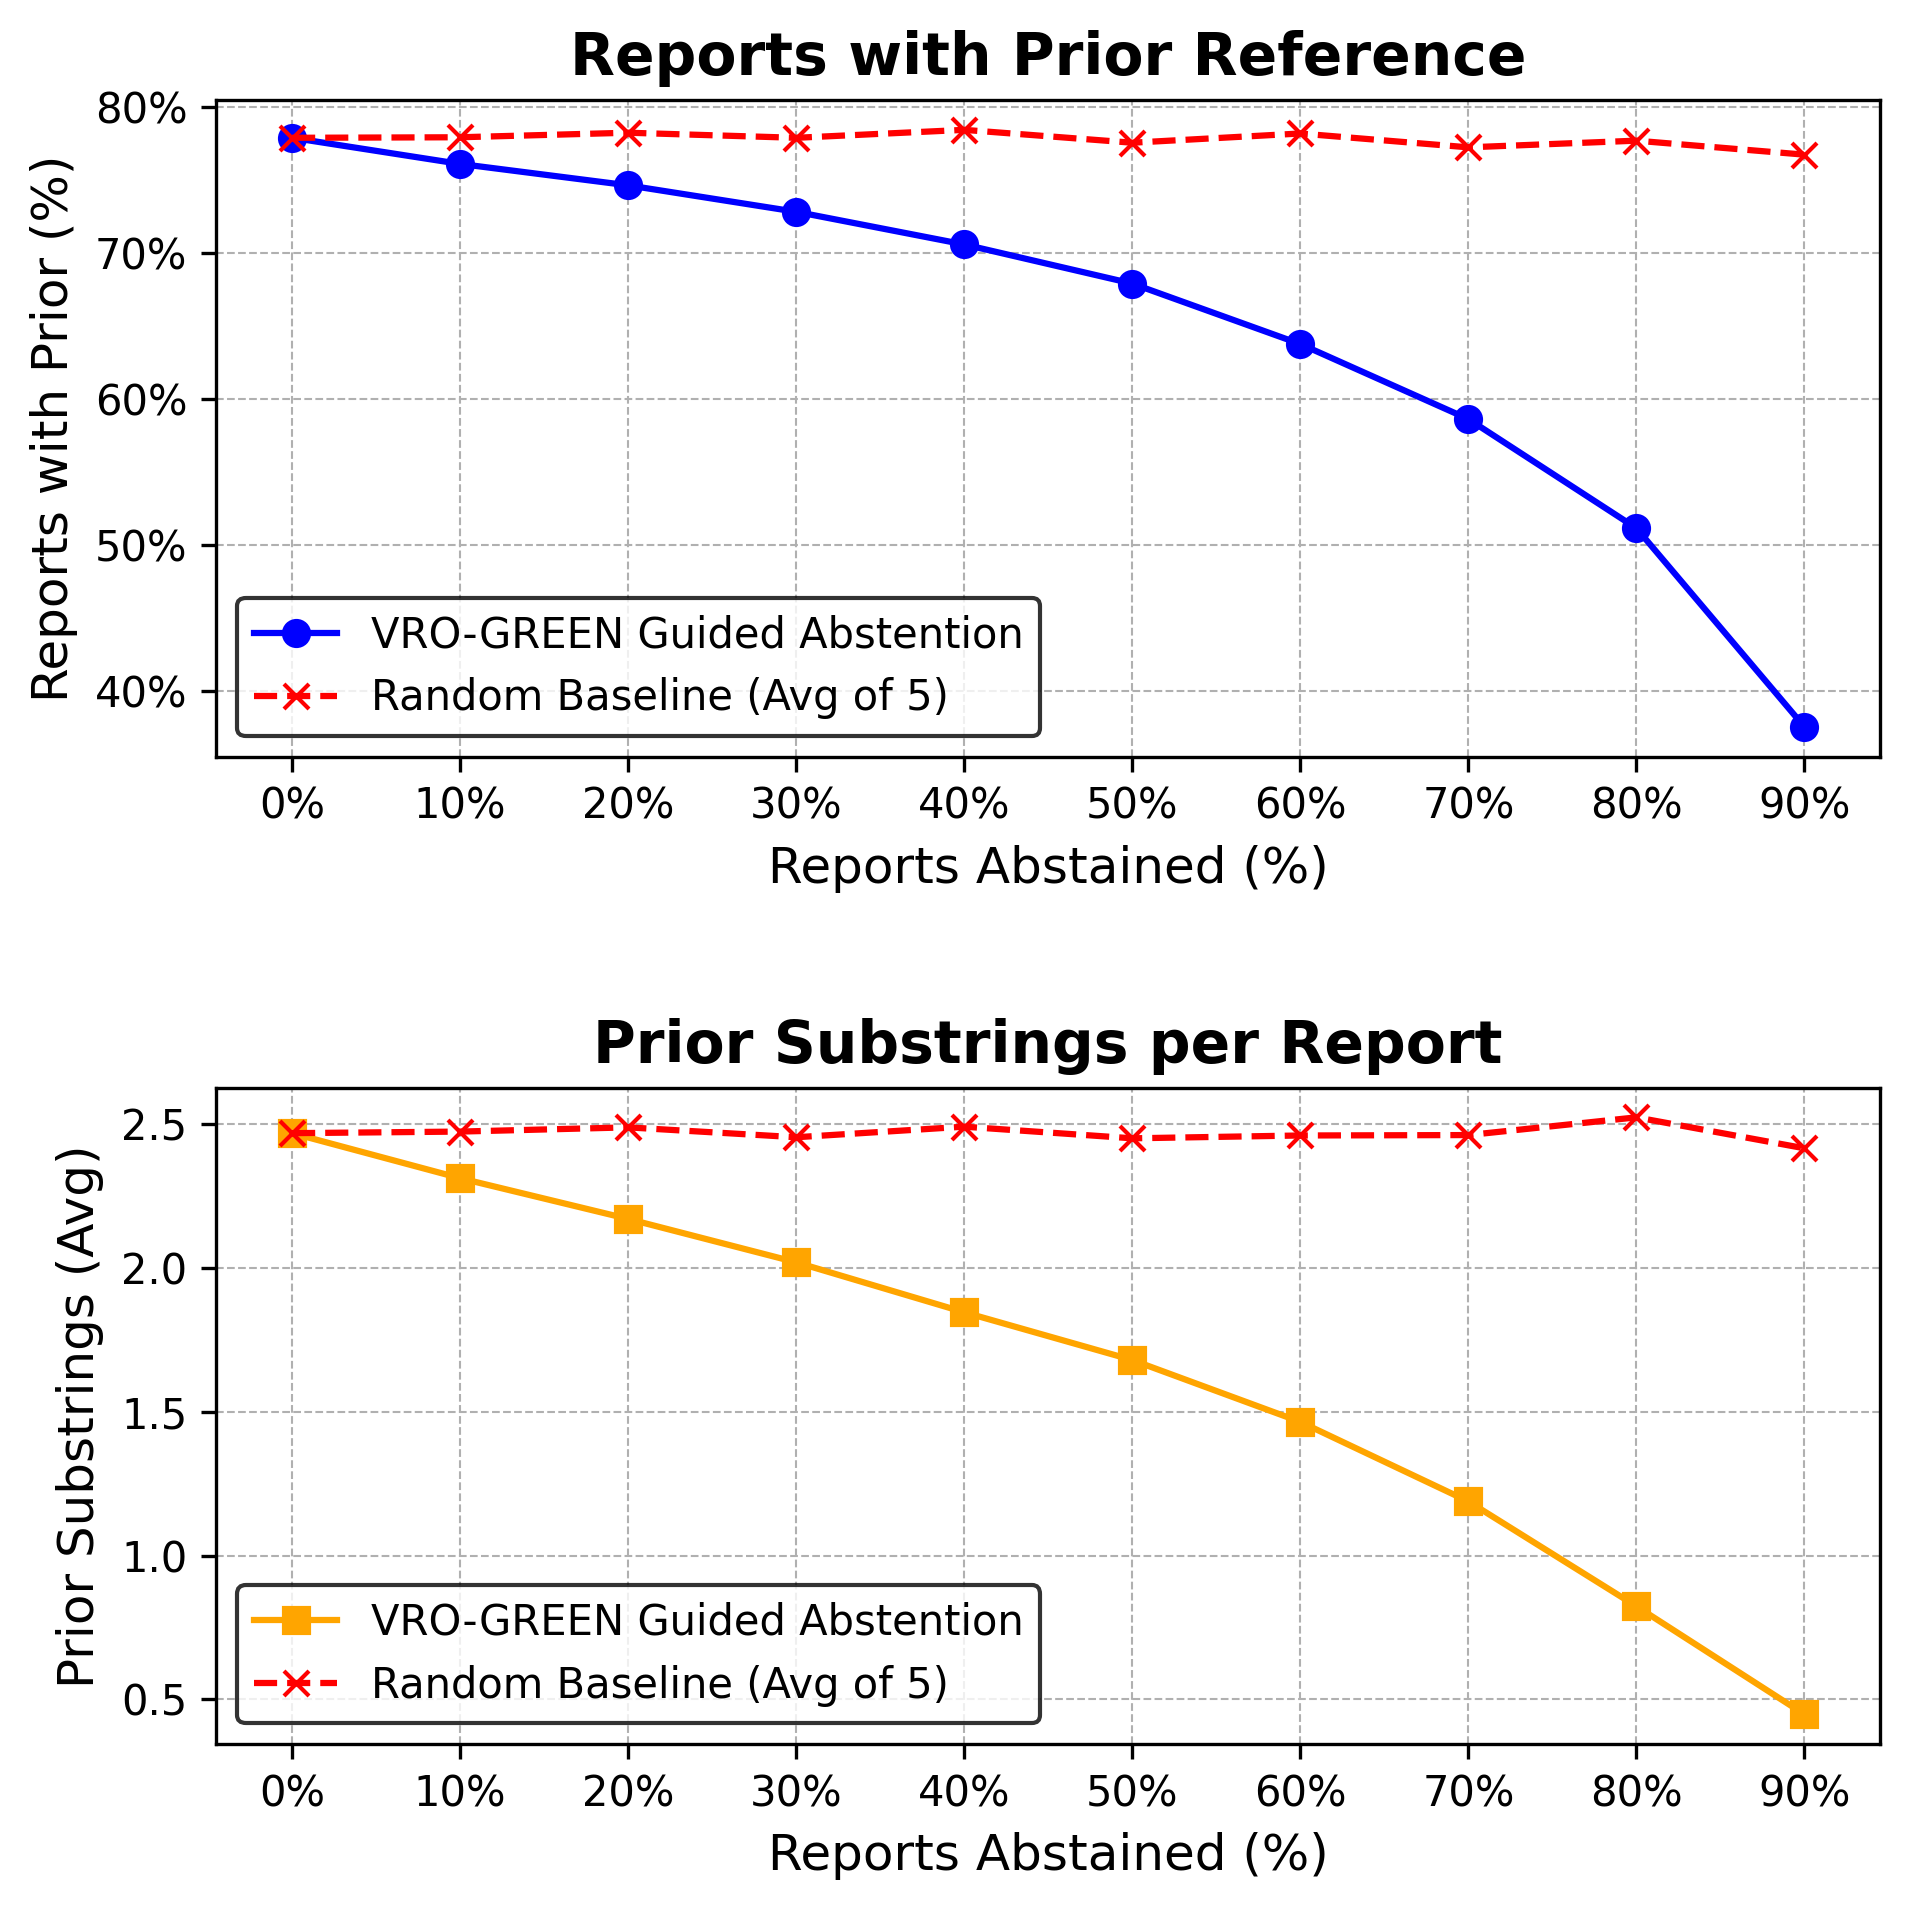

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all required functions and data are already defined as in the previous example.

# Initialize lists to store results for original data
percent_reports_with_prior = []
num_prior_substrings_per_report = []

# Calculate the original substring count for all reports
substring_count_dict = count_substrings(pred, reference_substrings)
non_zero_count = sum(1 for count in substring_count_dict.values() if count > 0)

# Append initial results for the original data
percent_reports_with_prior.append(non_zero_count / len(substring_count_dict))
num_prior_substrings_per_report.append(np.mean(list(substring_count_dict.values())))

# Define top percentage values to examine
top_percent_values = np.arange(0, 1.0, 0.1)

# Initialize lists to store random baseline results
random_percent_reports_with_prior_avg = [percent_reports_with_prior[0]]
random_num_prior_substrings_per_report_avg = [num_prior_substrings_per_report[0]]

for top_percent in top_percent_values[1:]:
    top_substring_count_dict, _ = exclude_top_uncertainty_analysis(pred, reference_substrings, ugreen, top_percent=top_percent)
    non_zero_count = sum(1 for count in top_substring_count_dict.values() if count > 0)
    percentage_with_prior = non_zero_count / len(top_substring_count_dict) if len(top_substring_count_dict) > 0 else 0
    avg_prior_substrings = np.mean(list(top_substring_count_dict.values())) if top_substring_count_dict else 0
    
    percent_reports_with_prior.append(percentage_with_prior)
    num_prior_substrings_per_report.append(avg_prior_substrings)

    random_percent_reports_with_prior = []
    random_num_prior_substrings_per_report = []
    
    for _ in range(5):  # Take 5 random samples
        _, random_substring_count_dict = exclude_top_uncertainty_analysis(pred, reference_substrings, ugreen, top_percent=top_percent)
        rd_non_zero_count = sum(1 for count in random_substring_count_dict.values() if count > 0)
        rd_percentage_with_prior = rd_non_zero_count / len(random_substring_count_dict) if len(random_substring_count_dict) > 0 else 0
        rd_avg_prior_substrings = np.mean(list(random_substring_count_dict.values())) if random_substring_count_dict else 0
        
        random_percent_reports_with_prior.append(rd_percentage_with_prior)
        random_num_prior_substrings_per_report.append(rd_avg_prior_substrings)
    
    random_percent_reports_with_prior_avg.append(np.mean(random_percent_reports_with_prior))
    random_num_prior_substrings_per_report_avg.append(np.mean(random_num_prior_substrings_per_report))

# Plotting the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), dpi=300)

# Convert top_percent_values to percentages for the x-axis labels
top_percent_labels = [f"{int(x * 100)}%" for x in top_percent_values]

# Plot 1: Percentage of reports with prior reference
ax1.plot(top_percent_values, [p * 100 for p in percent_reports_with_prior], marker='o', linestyle='-', linewidth=1.5, markersize=6, color='blue', label='VRO-GREEN Guided Abstention')
ax1.plot(top_percent_values, [p * 100 for p in random_percent_reports_with_prior_avg], marker='x', linestyle='--', linewidth=1.5, markersize=6, color='red', label='Random Baseline (Avg of 5)')
ax1.set_title('Reports with Prior Reference', fontsize=14, weight='bold')
ax1.set_xlabel('Reports Abstained (%)', fontsize=12)
ax1.set_ylabel('Reports with Prior (%)', fontsize=12)
ax1.set_xticks(top_percent_values)
ax1.set_xticklabels(top_percent_labels)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.legend(fontsize=10, loc='lower left', frameon=True, edgecolor='black')
# Format y-axis to show percentage symbols
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Plot 2: Average number of prior substrings per report
ax2.plot(top_percent_values, num_prior_substrings_per_report, marker='s', linestyle='-', linewidth=1.5, markersize=6, color='orange', label='VRO-GREEN Guided Abstention')
ax2.plot(top_percent_values, random_num_prior_substrings_per_report_avg, marker='x', linestyle='--', linewidth=1.5, markersize=6, color='red', label='Random Baseline (Avg of 5)')
ax2.set_title('Prior Substrings per Report', fontsize=14, weight='bold')
ax2.set_xlabel('Reports Abstained (%)', fontsize=12)
ax2.set_ylabel('Prior Substrings (Avg)', fontsize=12)
ax2.set_xticks(top_percent_values)
ax2.set_xticklabels(top_percent_labels)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.legend(fontsize=10, loc='lower left', frameon=True, edgecolor='black')

# Adjust layout and save plot as 'figure3.png'
plt.tight_layout(pad=3.0)
plt.savefig('figure3.png', format='png')
plt.show()
plt.close()


# second model

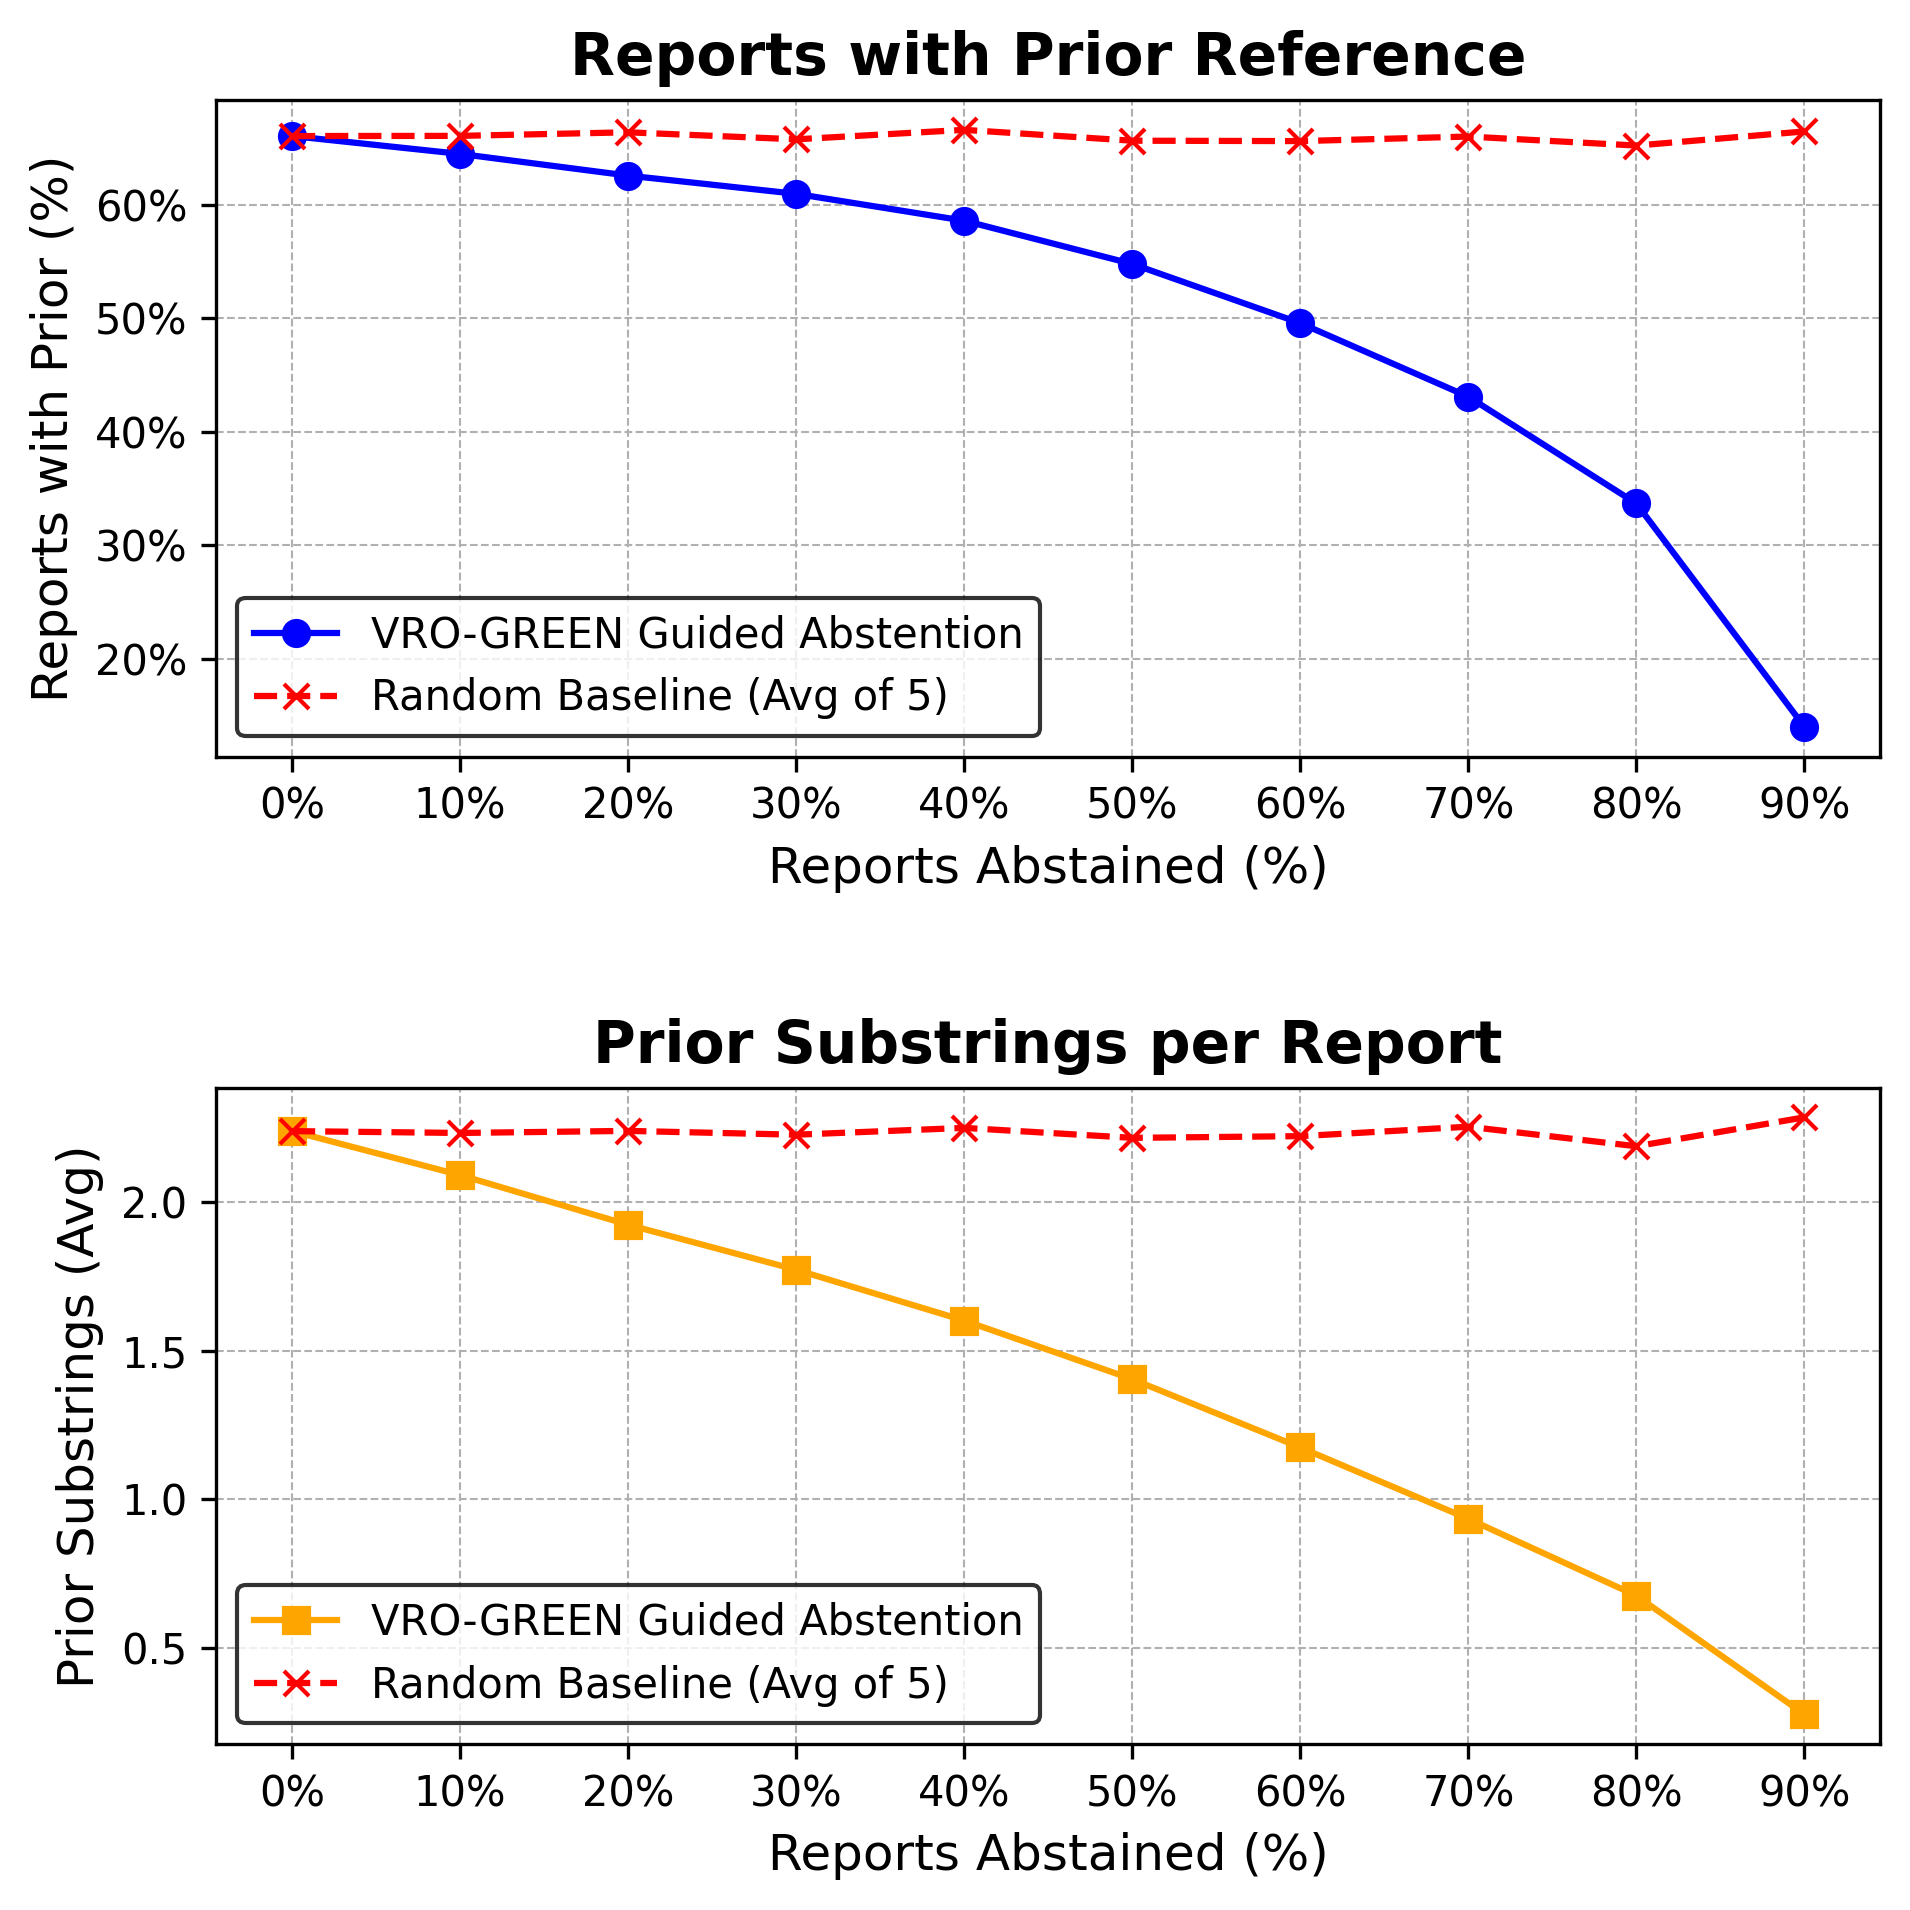

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all required functions and data are already defined as in the previous example.

# Initialize lists to store results for original data
percent_reports_with_prior = []
num_prior_substrings_per_report = []

# Calculate the original substring count for all reports
substring_count_dict = count_substrings(pred, reference_substrings)
non_zero_count = sum(1 for count in substring_count_dict.values() if count > 0)

# Append initial results for the original data
percent_reports_with_prior.append(non_zero_count / len(substring_count_dict))
num_prior_substrings_per_report.append(np.mean(list(substring_count_dict.values())))

# Define top percentage values to examine
top_percent_values = np.arange(0, 1.0, 0.1)

# Initialize lists to store random baseline results
random_percent_reports_with_prior_avg = [percent_reports_with_prior[0]]
random_num_prior_substrings_per_report_avg = [num_prior_substrings_per_report[0]]

for top_percent in top_percent_values[1:]:
    top_substring_count_dict, _ = exclude_top_uncertainty_analysis(pred, reference_substrings, ugreen, top_percent=top_percent)
    non_zero_count = sum(1 for count in top_substring_count_dict.values() if count > 0)
    percentage_with_prior = non_zero_count / len(top_substring_count_dict) if len(top_substring_count_dict) > 0 else 0
    avg_prior_substrings = np.mean(list(top_substring_count_dict.values())) if top_substring_count_dict else 0
    
    percent_reports_with_prior.append(percentage_with_prior)
    num_prior_substrings_per_report.append(avg_prior_substrings)

    random_percent_reports_with_prior = []
    random_num_prior_substrings_per_report = []
    
    for _ in range(5):  # Take 5 random samples
        _, random_substring_count_dict = exclude_top_uncertainty_analysis(pred, reference_substrings, ugreen, top_percent=top_percent)
        rd_non_zero_count = sum(1 for count in random_substring_count_dict.values() if count > 0)
        rd_percentage_with_prior = rd_non_zero_count / len(random_substring_count_dict) if len(random_substring_count_dict) > 0 else 0
        rd_avg_prior_substrings = np.mean(list(random_substring_count_dict.values())) if random_substring_count_dict else 0
        
        random_percent_reports_with_prior.append(rd_percentage_with_prior)
        random_num_prior_substrings_per_report.append(rd_avg_prior_substrings)
    
    random_percent_reports_with_prior_avg.append(np.mean(random_percent_reports_with_prior))
    random_num_prior_substrings_per_report_avg.append(np.mean(random_num_prior_substrings_per_report))

# Plotting the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), dpi=300)

# Convert top_percent_values to percentages for the x-axis labels
top_percent_labels = [f"{int(x * 100)}%" for x in top_percent_values]

# Plot 1: Percentage of reports with prior reference
ax1.plot(top_percent_values, [p * 100 for p in percent_reports_with_prior], marker='o', linestyle='-', linewidth=1.5, markersize=6, color='blue', label='VRO-GREEN Guided Abstention')
ax1.plot(top_percent_values, [p * 100 for p in random_percent_reports_with_prior_avg], marker='x', linestyle='--', linewidth=1.5, markersize=6, color='red', label='Random Baseline (Avg of 5)')
ax1.set_title('Reports with Prior Reference', fontsize=14, weight='bold')
ax1.set_xlabel('Reports Abstained (%)', fontsize=12)
ax1.set_ylabel('Reports with Prior (%)', fontsize=12)
ax1.set_xticks(top_percent_values)
ax1.set_xticklabels(top_percent_labels)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.legend(fontsize=10, loc='lower left', frameon=True, edgecolor='black')
# Format y-axis to show percentage symbols
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Plot 2: Average number of prior substrings per report
ax2.plot(top_percent_values, num_prior_substrings_per_report, marker='s', linestyle='-', linewidth=1.5, markersize=6, color='orange', label='VRO-GREEN Guided Abstention')
ax2.plot(top_percent_values, random_num_prior_substrings_per_report_avg, marker='x', linestyle='--', linewidth=1.5, markersize=6, color='red', label='Random Baseline (Avg of 5)')
ax2.set_title('Prior Substrings per Report', fontsize=14, weight='bold')
ax2.set_xlabel('Reports Abstained (%)', fontsize=12)
ax2.set_ylabel('Prior Substrings (Avg)', fontsize=12)
ax2.set_xticks(top_percent_values)
ax2.set_xticklabels(top_percent_labels)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.legend(fontsize=10, loc='lower left', frameon=True, edgecolor='black')

# Adjust layout and save plot as 'figure3.png'
plt.tight_layout(pad=3.0)
plt.savefig('figure3.png', format='png')
plt.show()
plt.close()
